# Time-Series Analysis

## Environment set up

Change the working directory to be able to work with the source-code.

In [1]:
import os
from pathlib import Path

WORKING_DIRECTORY = Path.cwd().parents[0]
os.chdir(WORKING_DIRECTORY)
os.getcwd()

'c:\\python\\personal\\nasa-bearings'

## Imports

In [2]:
from src.read import read_nasa_vibration_files_in_directory
from src.signals import get_resolution
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from loguru import logger
import polars as pl

## Inputs

The inputs have been obtained from the NASA bearings documentation:

In [3]:
INPUTS = {
    '1st_test': {'data_path': r'data\nasa_ims_bearing_dataset\1st_test\1st_test',
                  'column_names': ['channel_1', 'channel_2', 'channel_3', 'channel_4',
                                   'channel_5', 'channel_6', 'channel_7', 'channel_8'],
                 'faulty_channels': ['channel_5', 'channel_6', 'channel_7', 'channel_8']},
    '2nd_test': {'data_path': r'data\nasa_ims_bearing_dataset\2nd_test\2nd_test',
                 'column_names': ['channel_1', 'channel_2', 'channel_3', 'channel_4'],
                 'faulty_channels': ['channel_1']},
    '3rd_test': {'data_path': r'data\nasa_ims_bearing_dataset\3rd_test\4th_test\txt',
                 'column_names': ['channel_1', 'channel_2', 'channel_3', 'channel_4'],
                 'faulty_channels': ['channel_3']}
          }

In [4]:
SAMPLING_RATE_IN_HERTZ = 20000
MEASUREMENT_DURATION_IN_SECONDS = 1
ACCEPTABLE_SENSOR_RANGE = 0.01

# Read the data

In [5]:
complete_data_path_per_test = {}

for test, inputs_per_test in INPUTS.items():
    for key, values in inputs_per_test.items():
        data_path = inputs_per_test['data_path']
        complete_path = WORKING_DIRECTORY.joinpath(data_path)
        complete_data_path_per_test[test] = complete_path

complete_data_path_per_test

{'1st_test': WindowsPath('c:/python/personal/nasa-bearings/data/nasa_ims_bearing_dataset/1st_test/1st_test'),
 '2nd_test': WindowsPath('c:/python/personal/nasa-bearings/data/nasa_ims_bearing_dataset/2nd_test/2nd_test'),
 '3rd_test': WindowsPath('c:/python/personal/nasa-bearings/data/nasa_ims_bearing_dataset/3rd_test/4th_test/txt')}

In [6]:
# pandas takes 6m 27.2s
# polars takes 2m 1.8s
signal_resolution = get_resolution(sampling_frequency=SAMPLING_RATE_IN_HERTZ)

df_list_per_test = {}
for test, file_path in complete_data_path_per_test.items():
    logger.info(f'test: {test}')
    column_names = INPUTS[test]['column_names']
    df_list = read_nasa_vibration_files_in_directory(files_path=file_path, sensors=column_names,
                                                     signal_resolution=signal_resolution,
                                                     acceptable_sensor_range=ACCEPTABLE_SENSOR_RANGE)
    df_list_per_test[test] = df_list

2025-12-02 17:32:26.094 | INFO     | __main__:<module>:7 - test: 1st_test
2025-12-02 17:32:52.115 | INFO     | __main__:<module>:7 - test: 2nd_test
2025-12-02 17:32:52.115 | INFO     | __main__:<module>:7 - test: 2nd_test
2025-12-02 17:33:06.015 | WARNING  | src.read:read_nasa_vibration_files_in_directory:63 - All sensors in file 2004.02.19.06.12.39 are faulty for the defined acceptable_sensor_range of 0.01. Skipping this file.
2025-12-02 17:33:06.030 | WARNING  | src.read:read_nasa_vibration_files_in_directory:63 - All sensors in file 2004.02.19.06.22.39 are faulty for the defined acceptable_sensor_range of 0.01. Skipping this file.
2025-12-02 17:33:06.015 | WARNING  | src.read:read_nasa_vibration_files_in_directory:63 - All sensors in file 2004.02.19.06.12.39 are faulty for the defined acceptable_sensor_range of 0.01. Skipping this file.
2025-12-02 17:33:06.030 | WARNING  | src.read:read_nasa_vibration_files_in_directory:63 - All sensors in file 2004.02.19.06.22.39 are faulty for the

# Time-series plots

The following plots show the first and last available measurements to see see how the data changes for a bearing while changes from healthy to faulty:

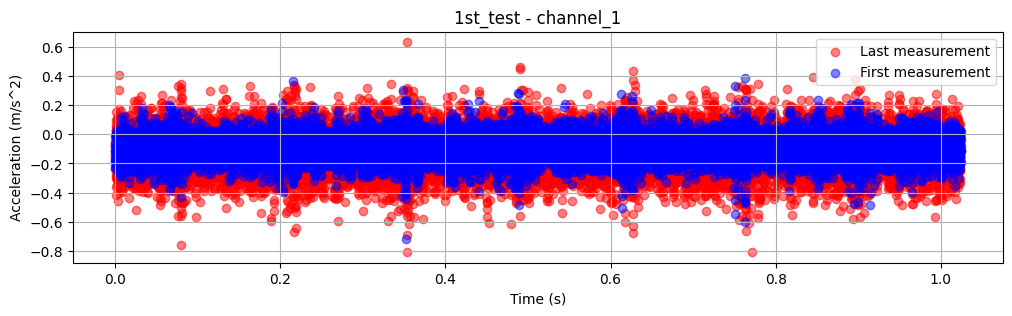

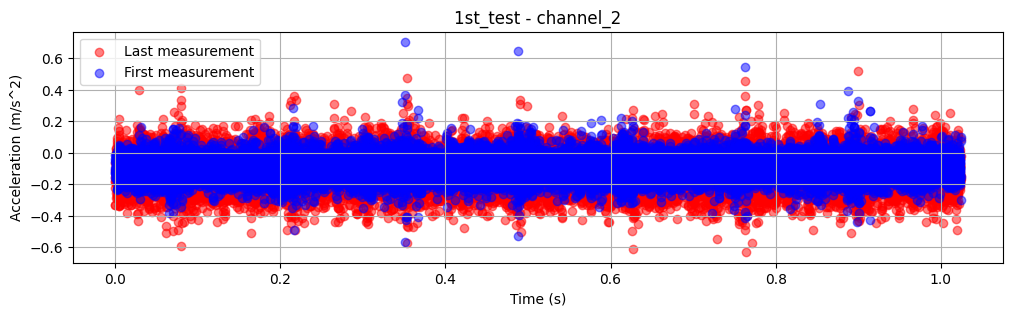

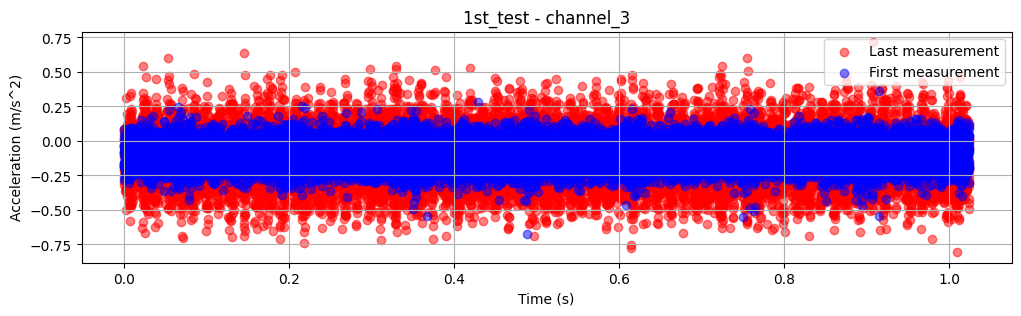

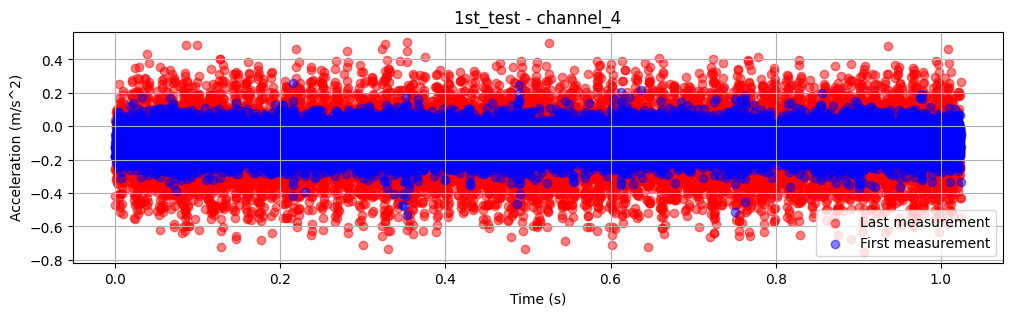

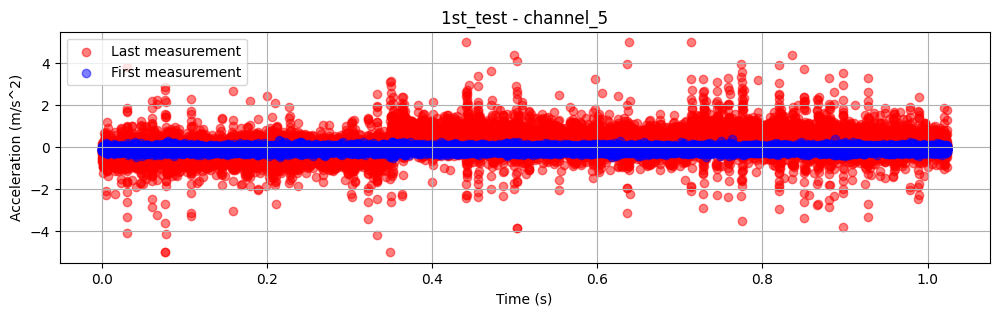

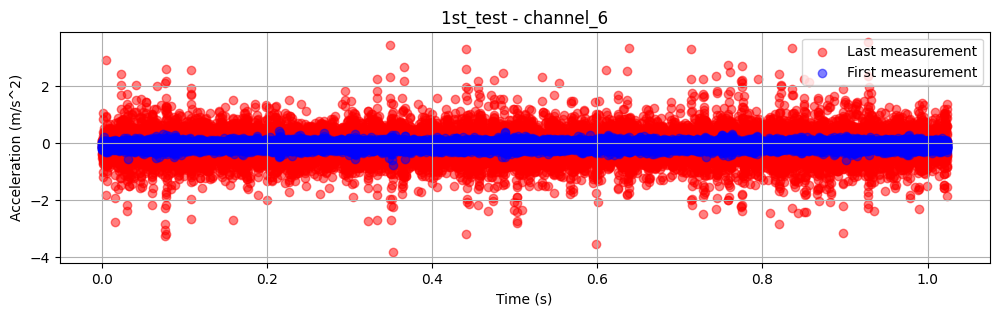

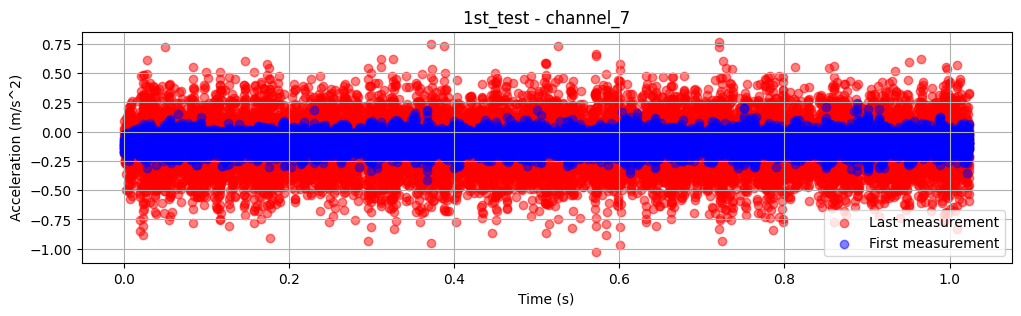

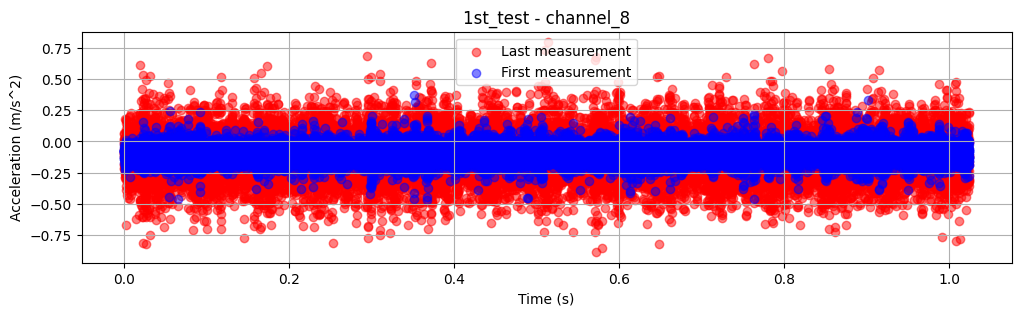

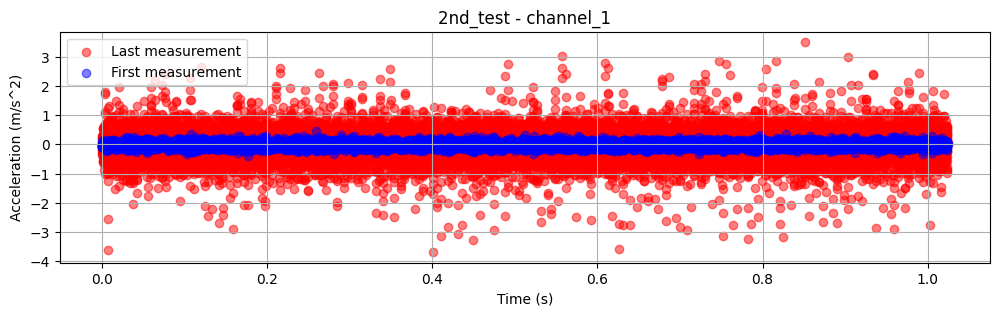

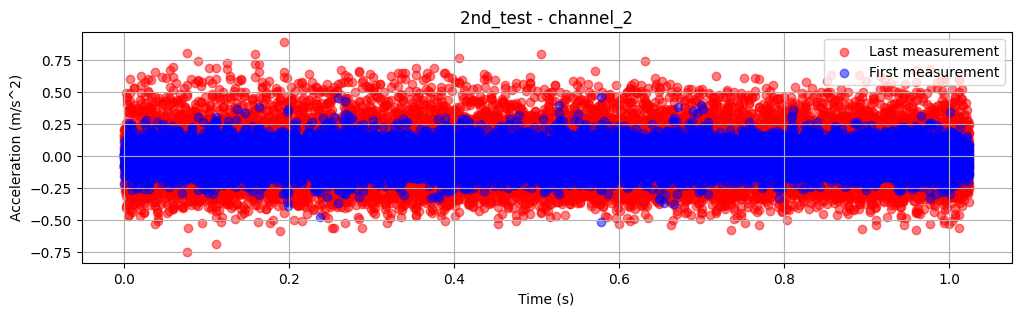

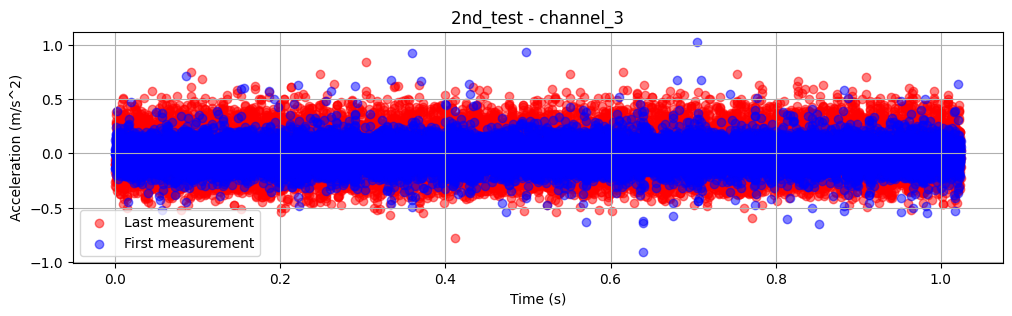

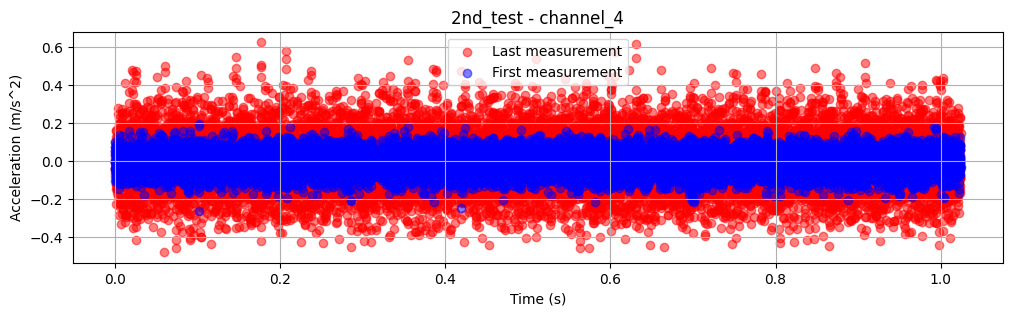

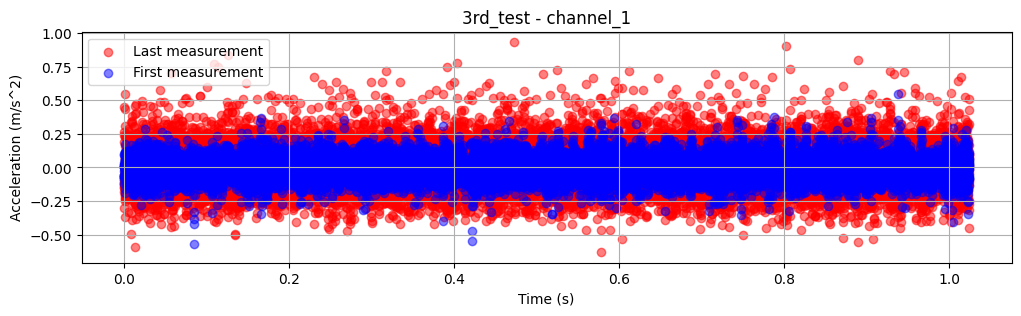

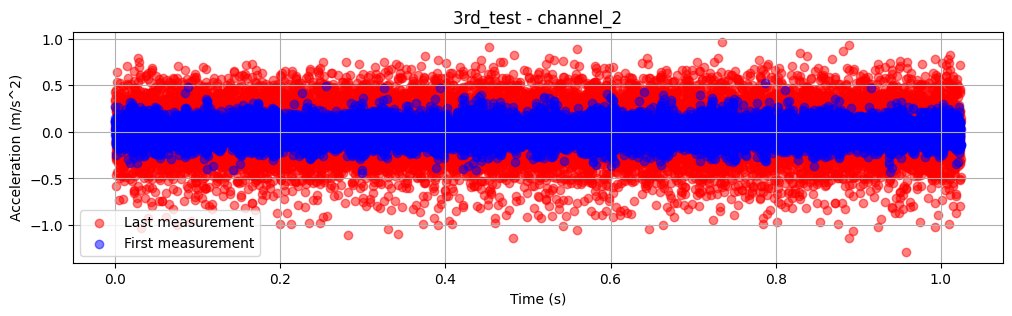

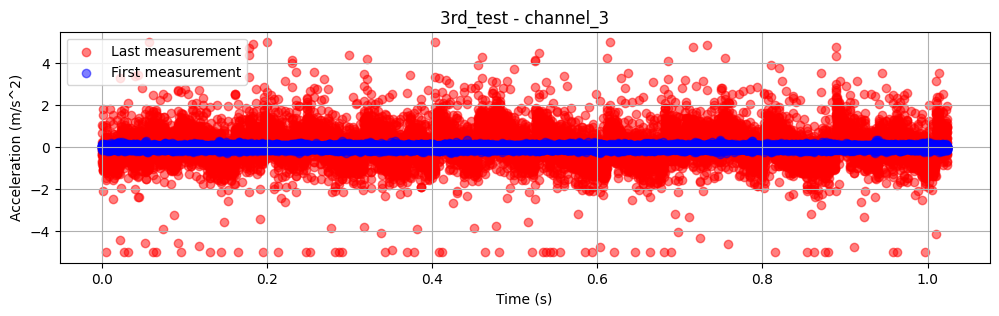

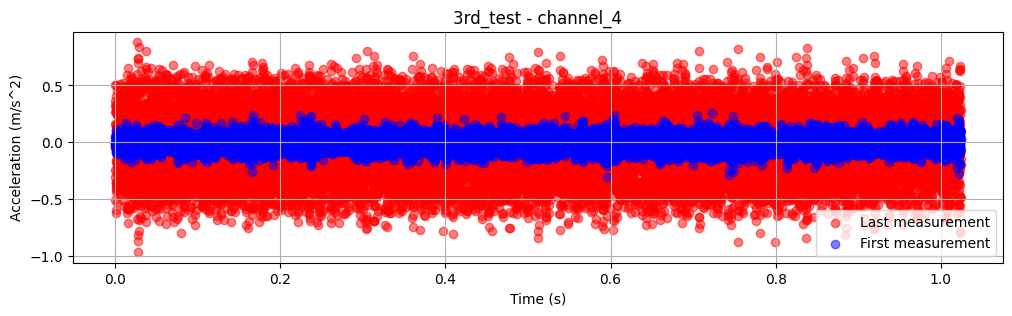

In [7]:
for test, df_list in df_list_per_test.items():
    column_names = INPUTS[test]['column_names']
    for channel in column_names:
        plt.figure(figsize=(12, 3))
        plt.scatter(df_list[-1]['measurement_time_in_seconds'], df_list[-1][channel], label='Last measurement', color='red', alpha=0.5)
        plt.scatter(df_list[0]['measurement_time_in_seconds'], df_list[0][channel], label='First measurement', color='blue', alpha=0.5)
        plt.legend()
        plt.grid()
        plt.xlabel('Time (s)')
        plt.ylabel('Acceleration (m/s^2)')
        plt.title(f'{test} - {channel}');

# Aggregation

Different aggregation functions are used to better understand the evolution of the failure using the time-series data:

In [33]:
AGGREGATION_FUNCTIONS = {
        "max": lambda c: pl.col(c).max(),
        "min": lambda c: pl.col(c).min(),
        "mean": lambda c: pl.col(c).mean(),
    }

In [ ]:
aggregated_df_per_test = {}

for test, df_list in df_list_per_test.items():
    print(f"test: {test}")
    df = pl.concat(df_list, how='vertical')
    faulty_channels = INPUTS[test]["faulty_channels"]
    exprs = [
        fn(col).alias(f"{stat}_{col}")
        for col in faulty_channels
        for stat, fn in AGGREGATION_FUNCTIONS.items()
    ]

    aggregated_df = (
        df
        .group_by("file_name")
        .agg(exprs)
    )

    # Convert file_name into datetime
    aggregated_df = aggregated_df.with_columns(
        pl.col("file_name").str.strptime(
            pl.Datetime,
            format="%Y.%m.%d.%H.%M.%S"
        ).alias("date_time")
    )

    aggregated_df_per_test[test] = aggregated_df

test: 1st_test


TypeError: ExprStringNameSpace.strptime() got an unexpected keyword argument 'fmt'

C:\Users\IkerDeLoma-Osorio\AppData\Local\Temp\ipykernel_8868\3320902847.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 2.5))


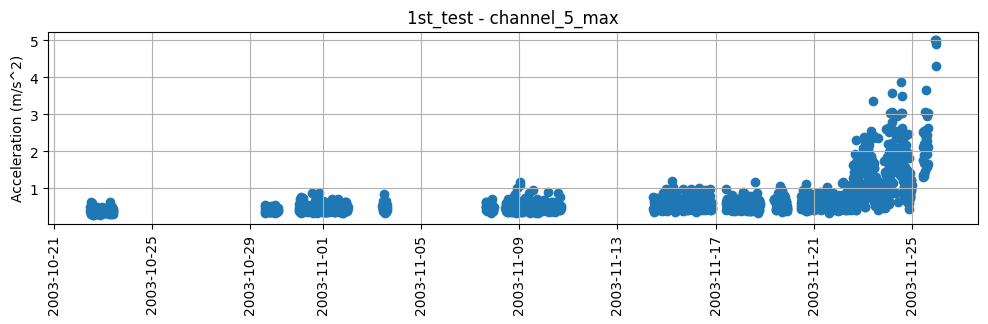

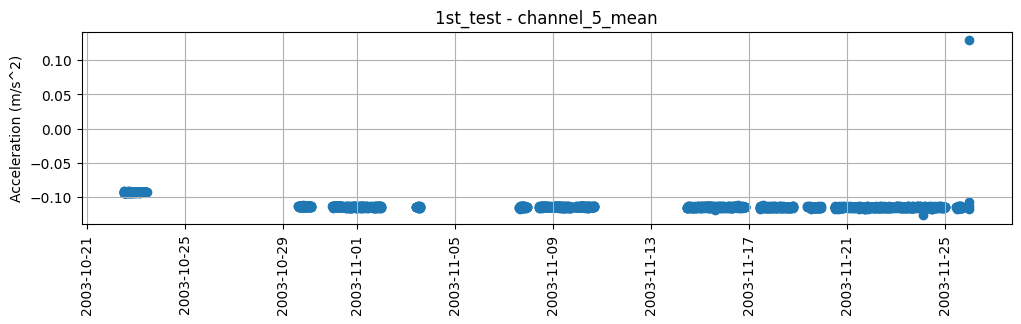

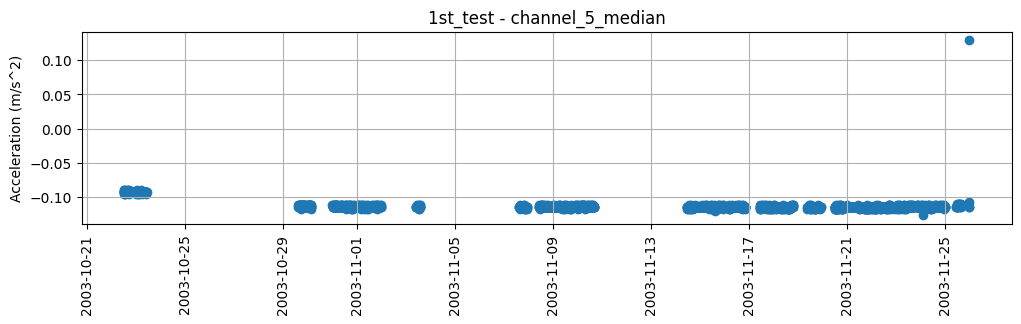

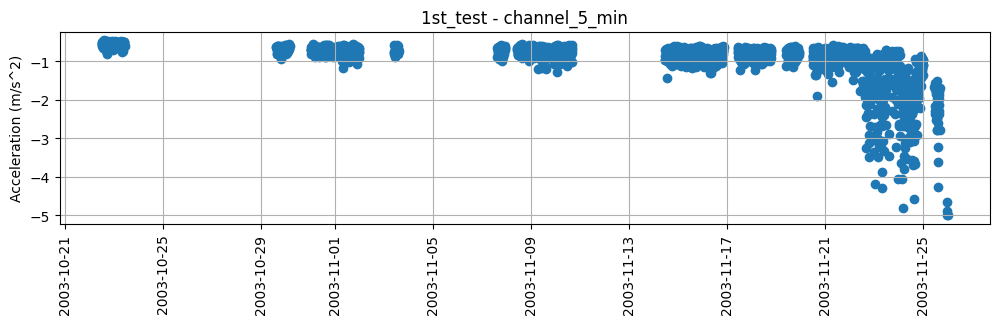

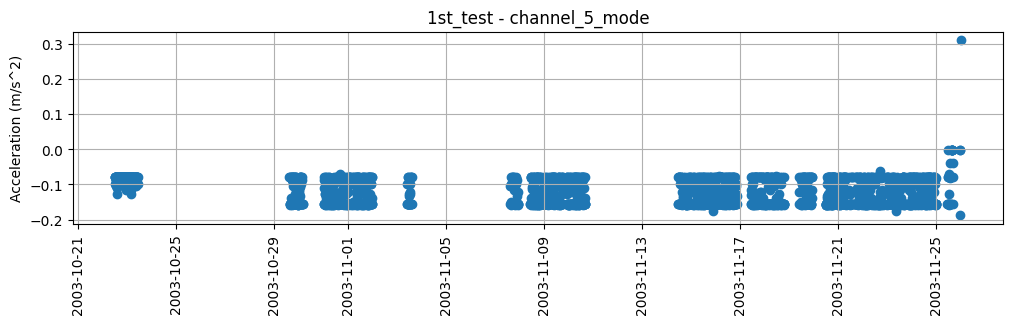

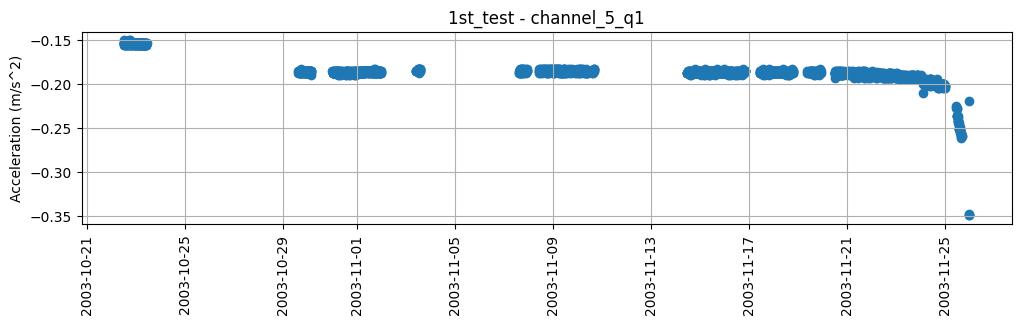

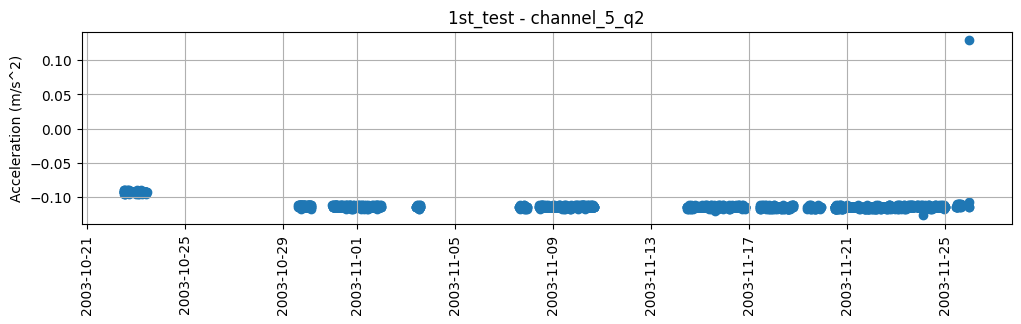

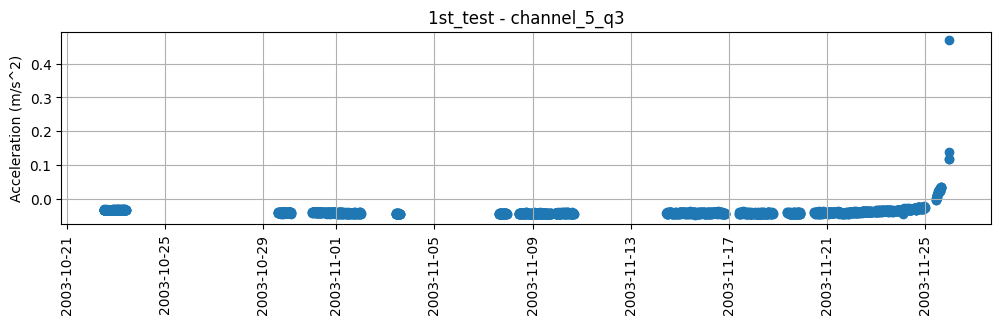

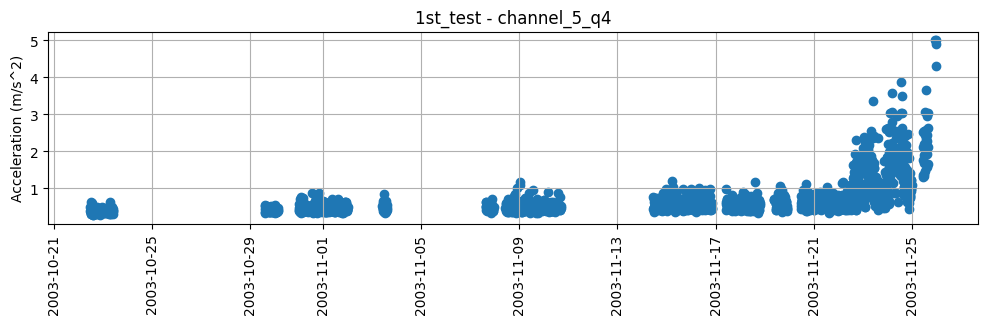

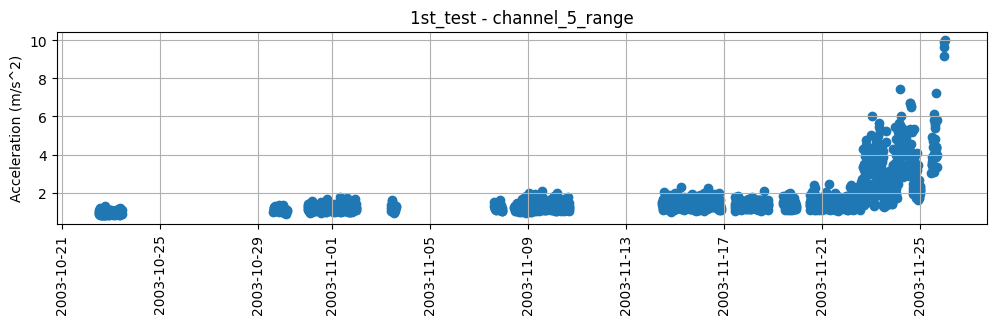

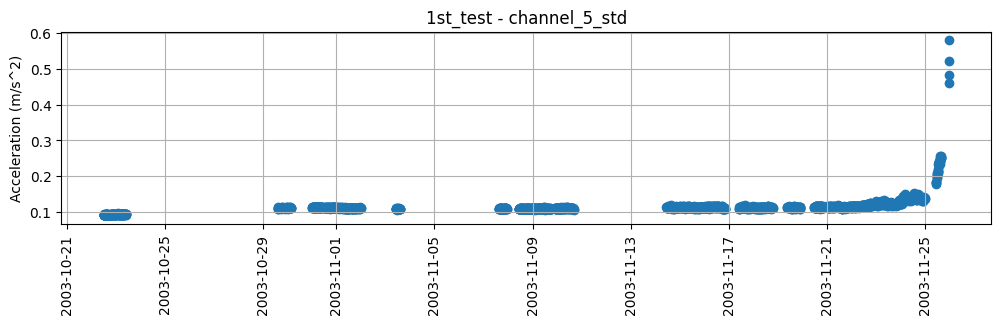

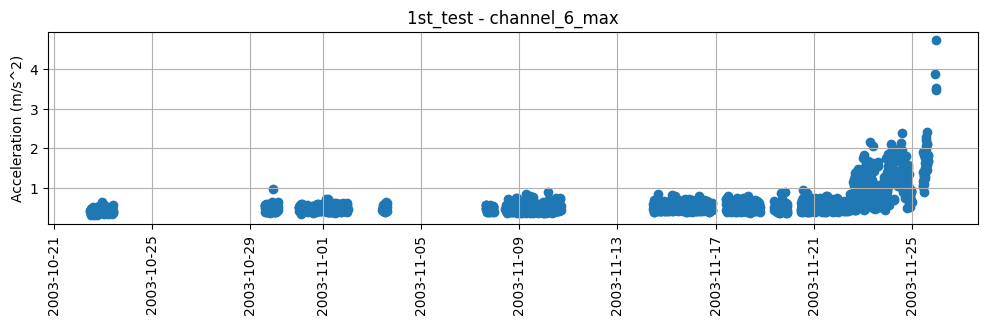

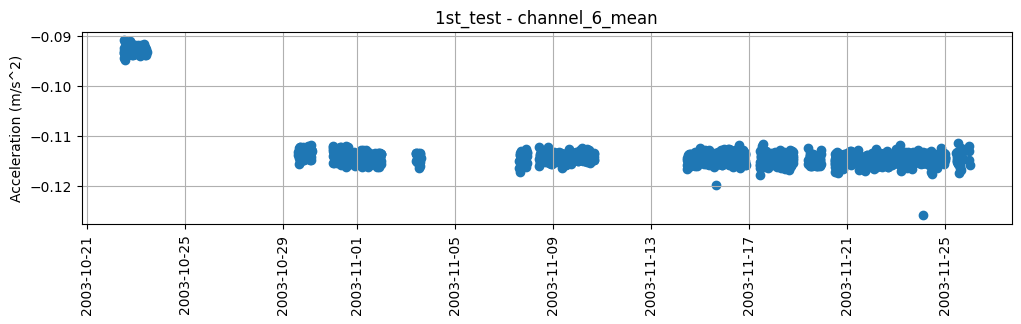

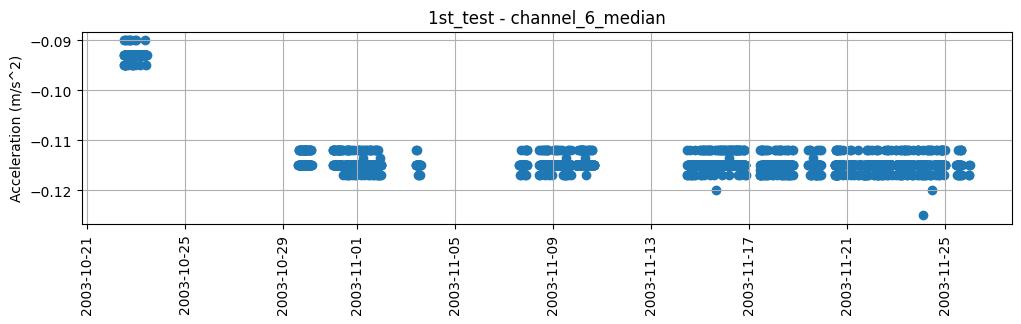

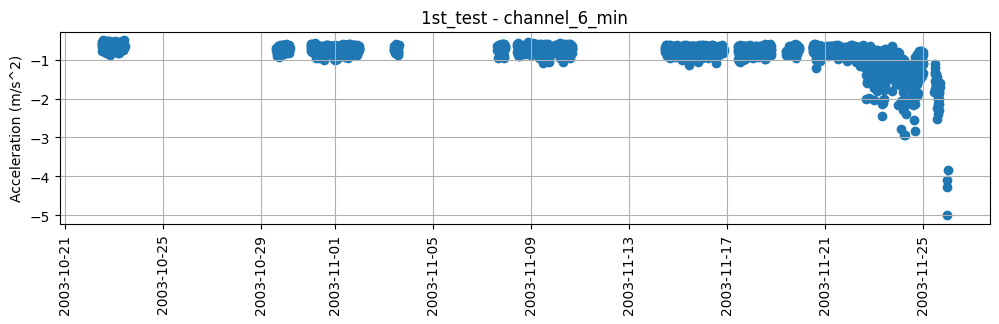

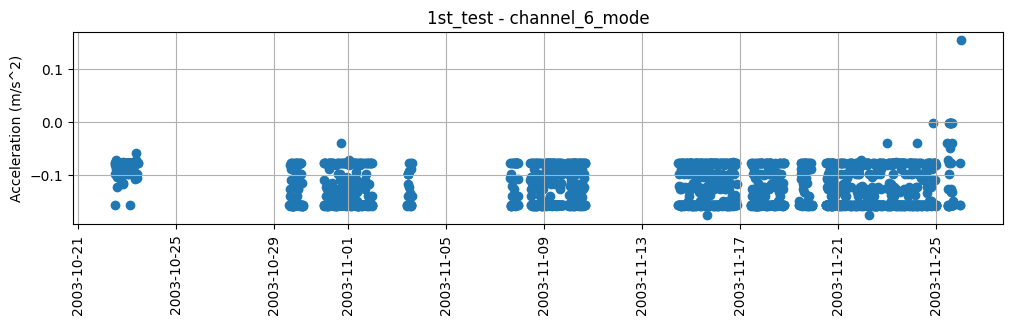

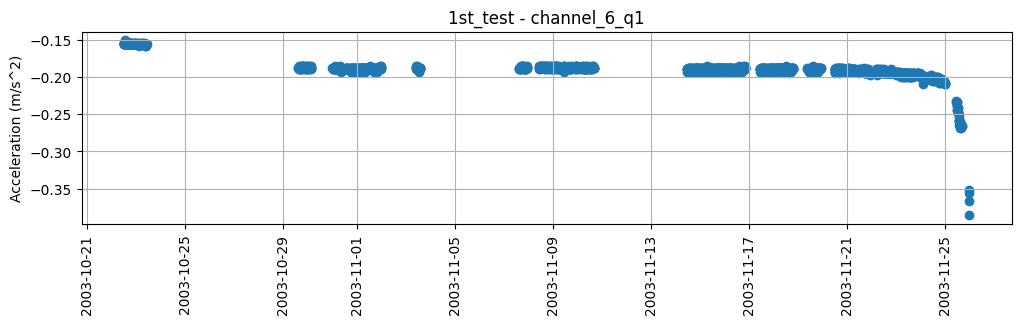

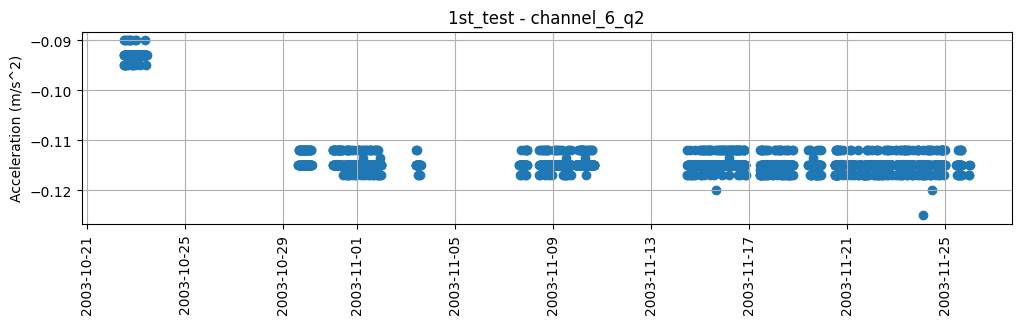

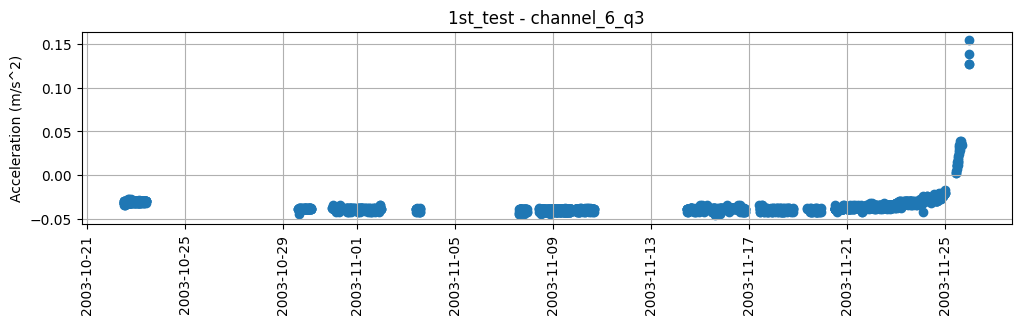

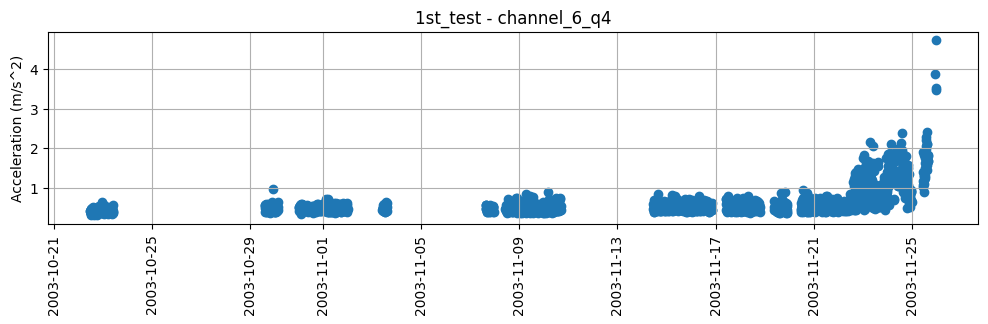

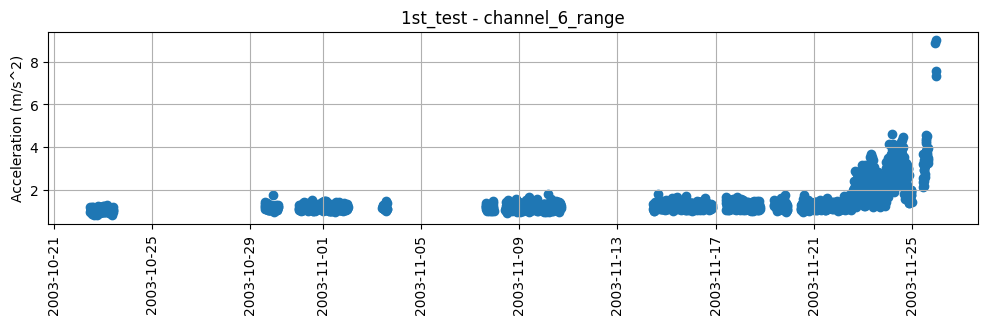

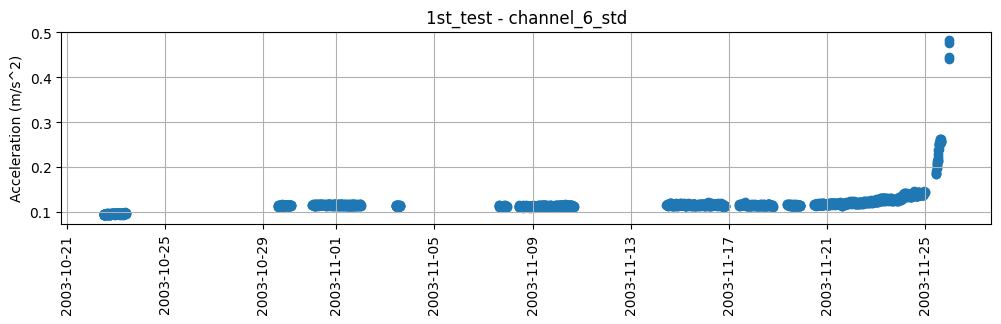

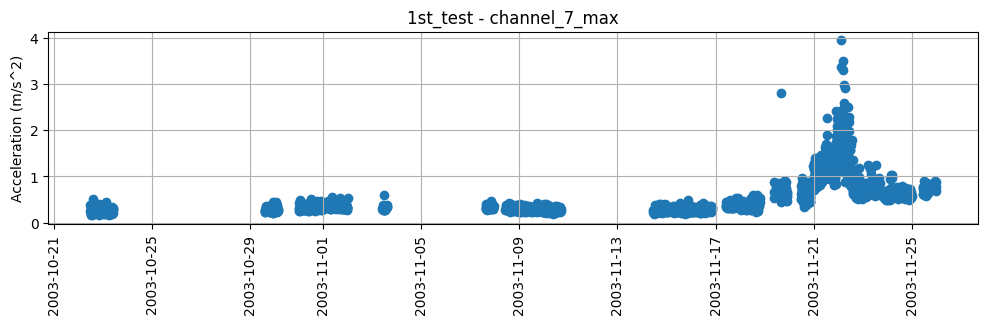

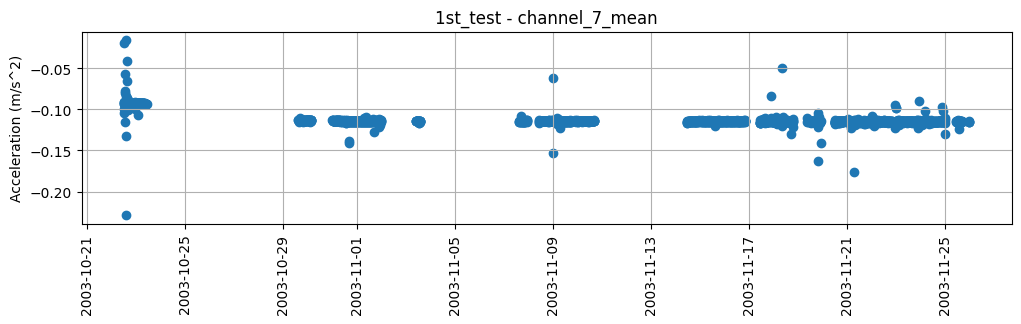

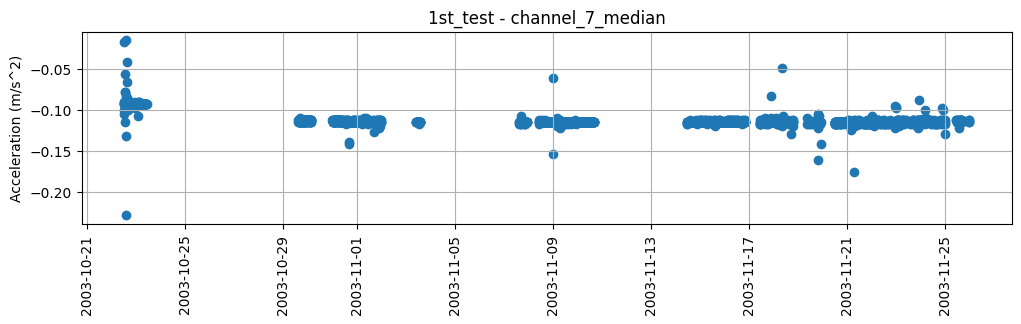

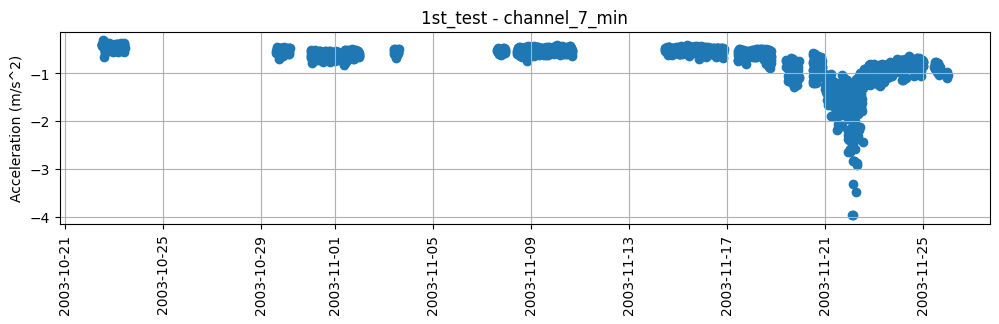

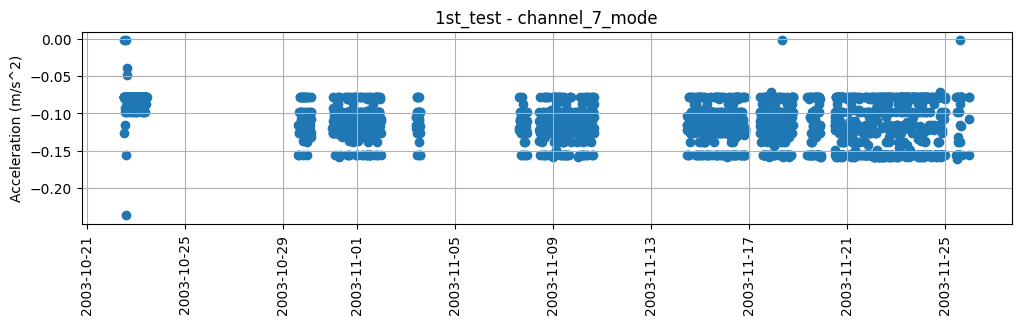

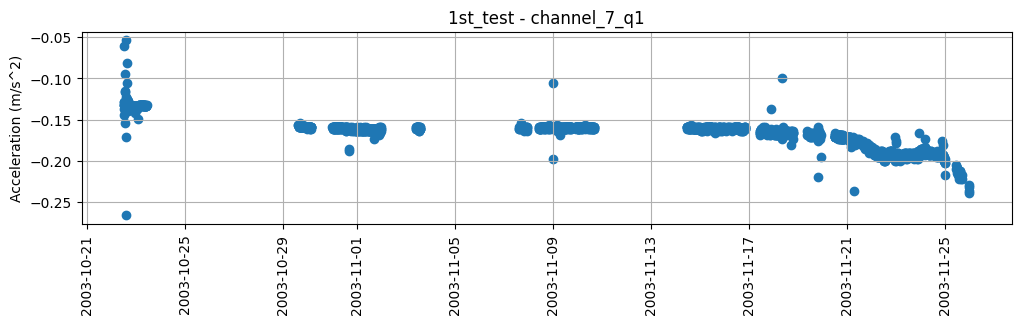

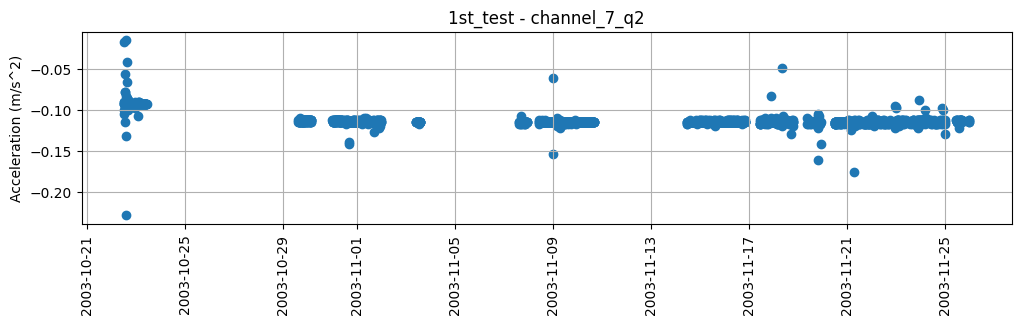

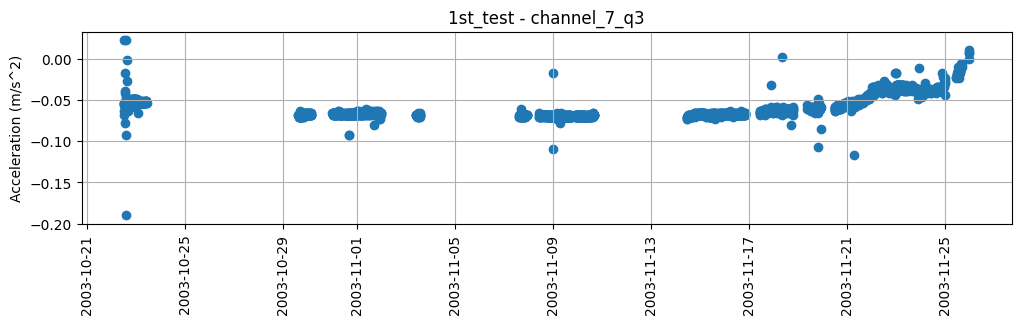

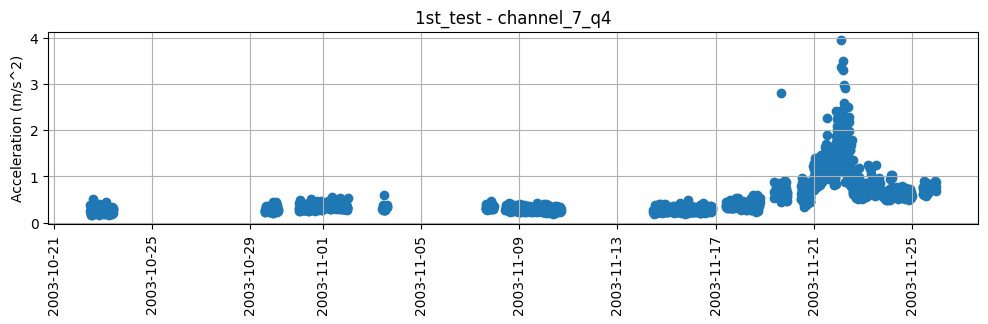

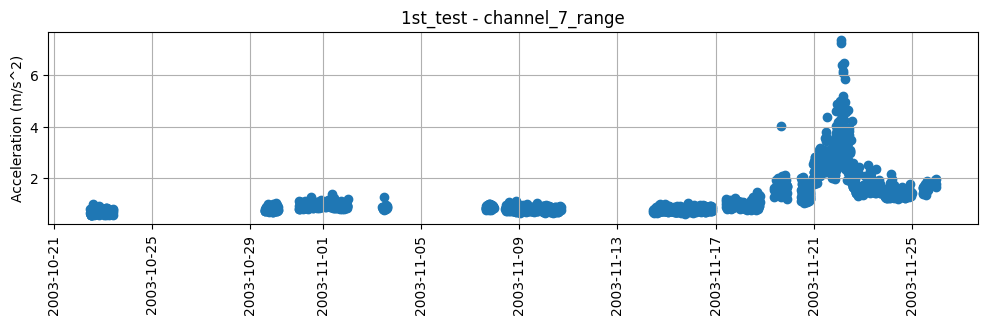

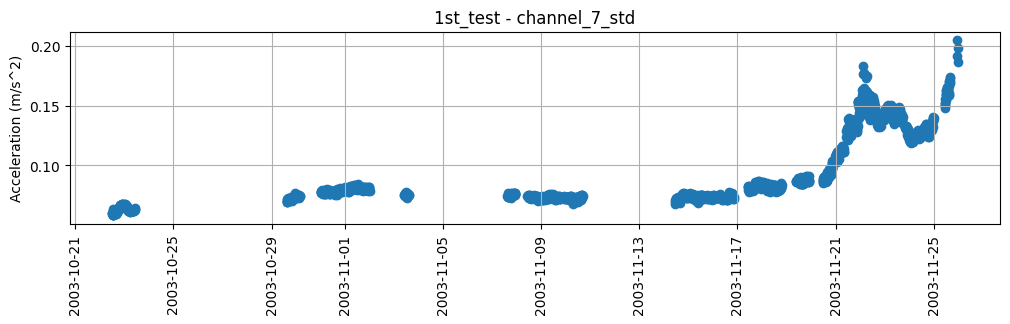

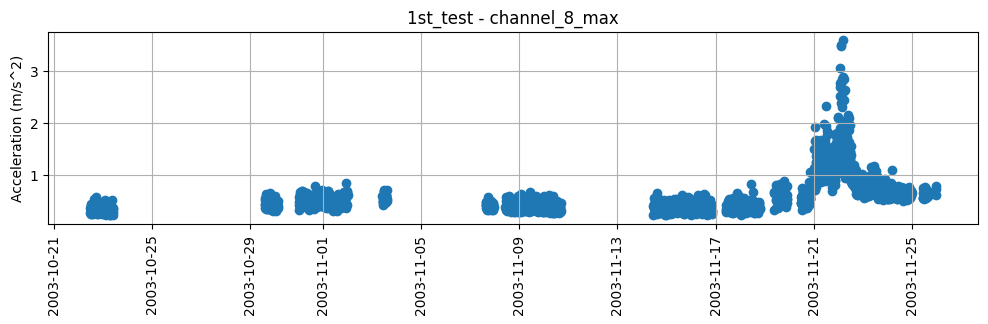

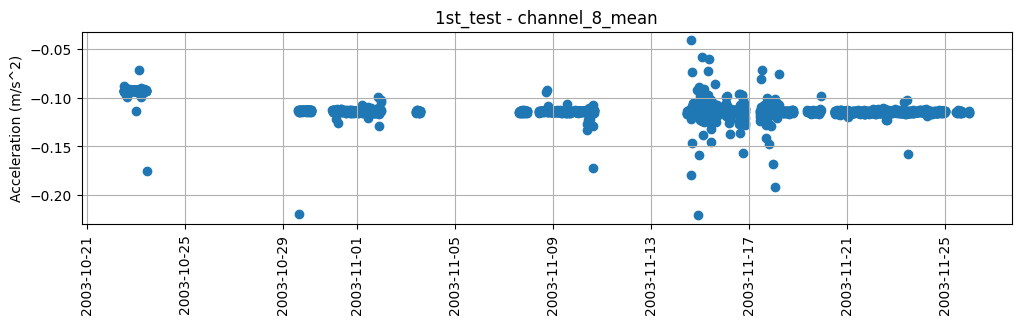

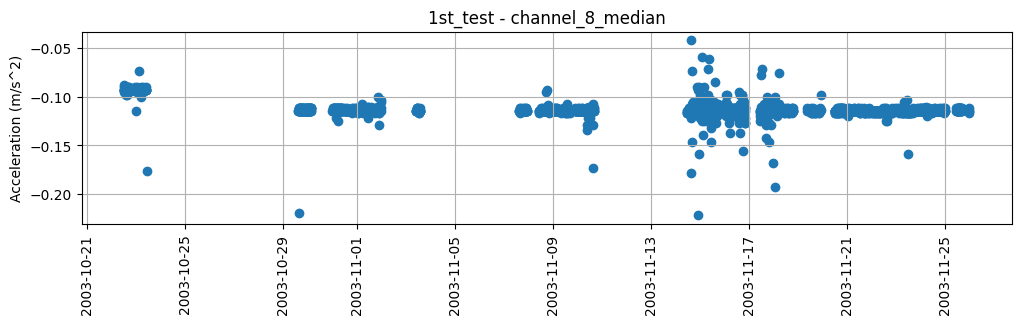

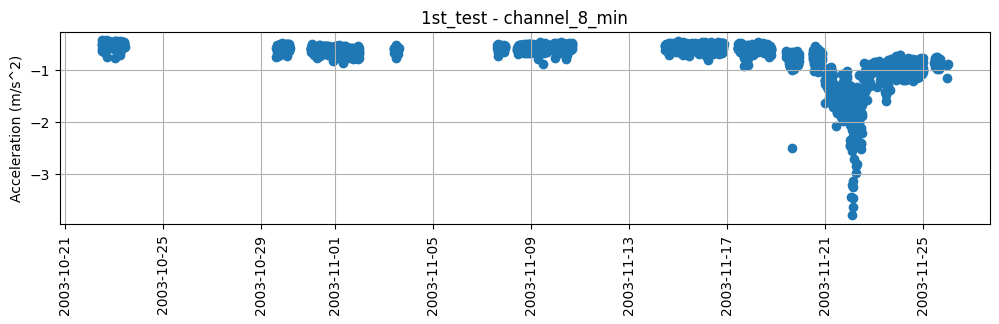

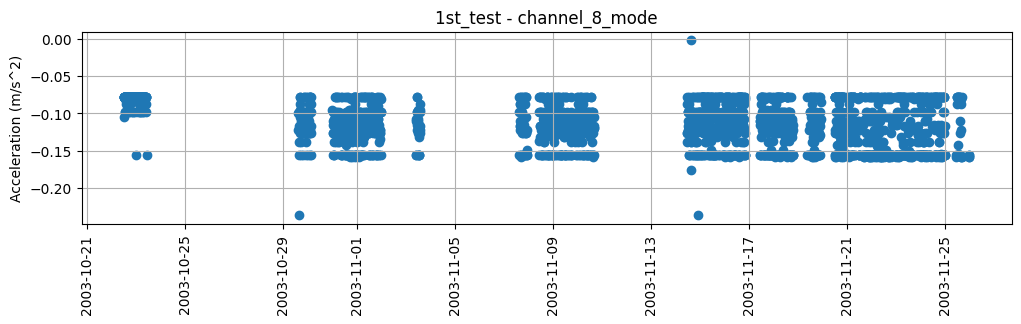

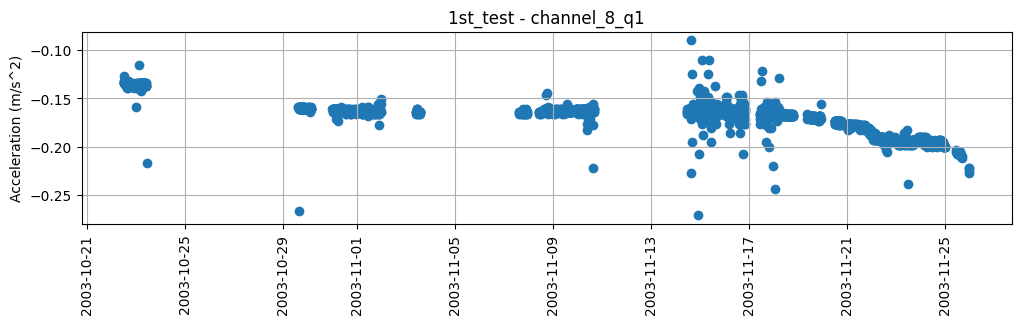

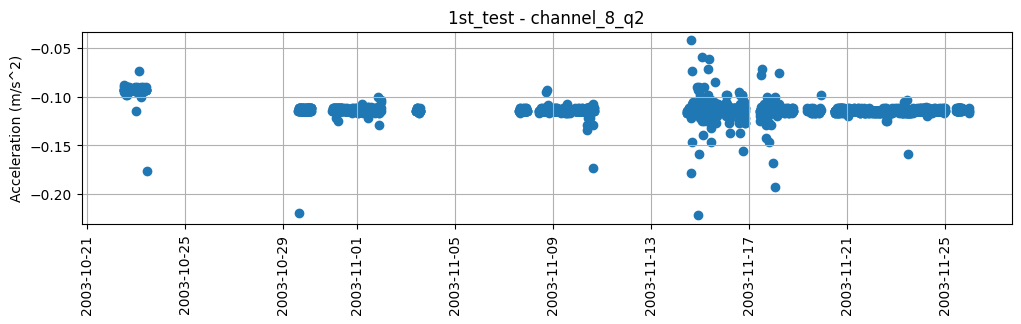

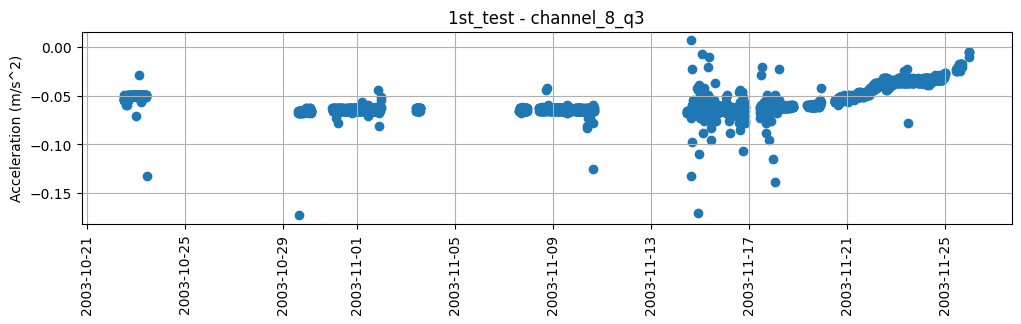

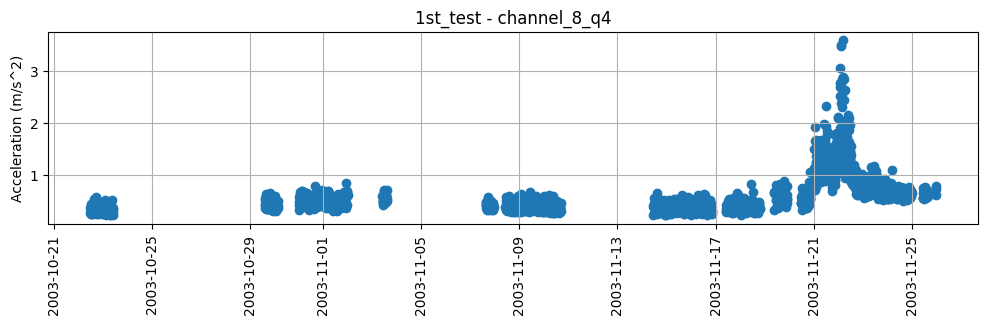

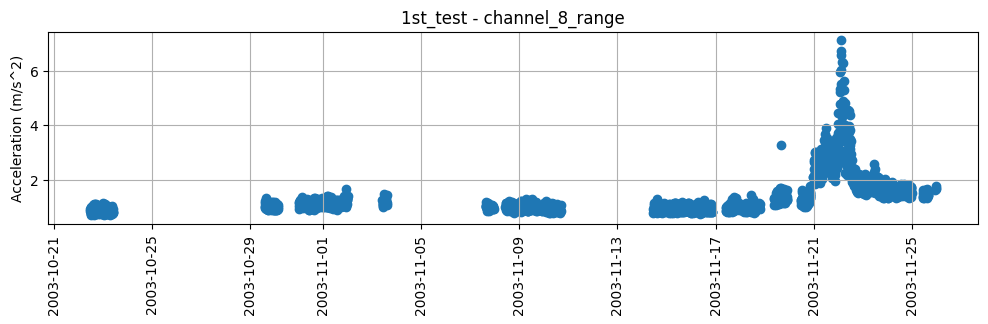

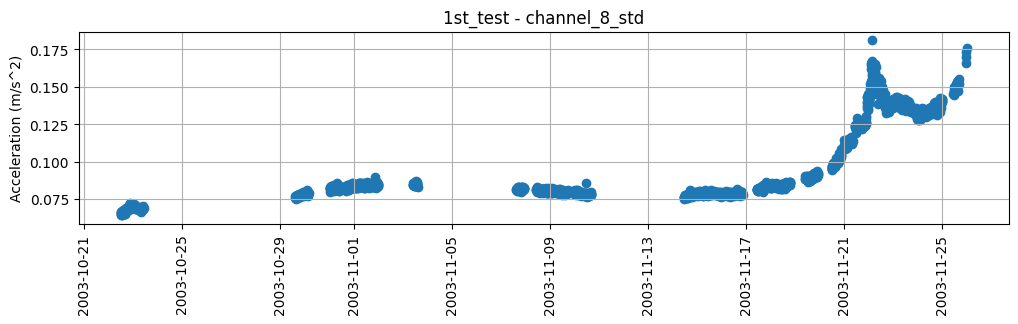

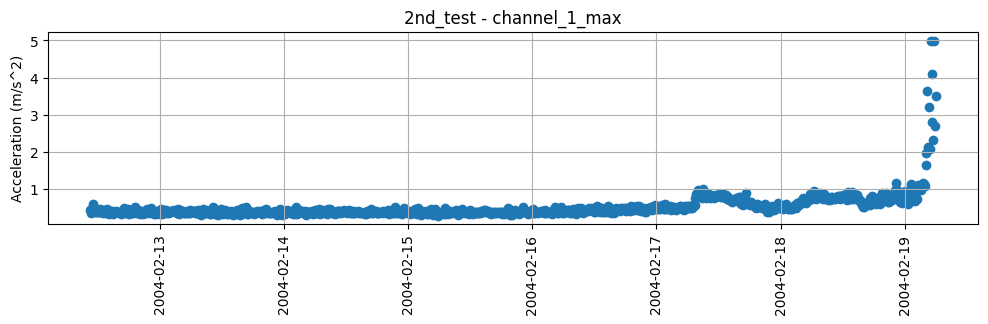

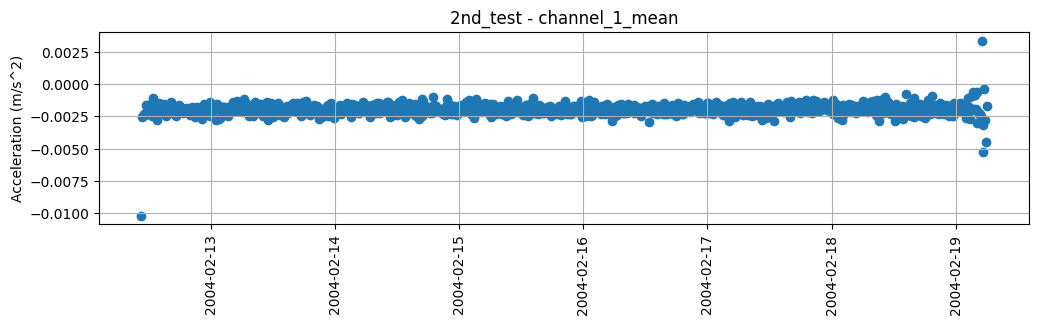

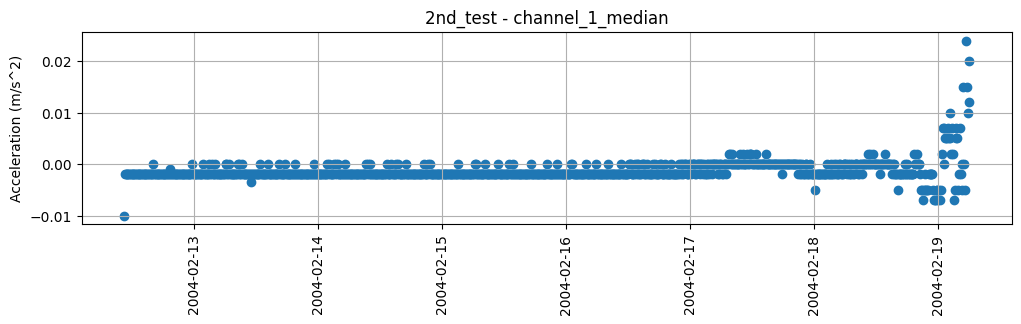

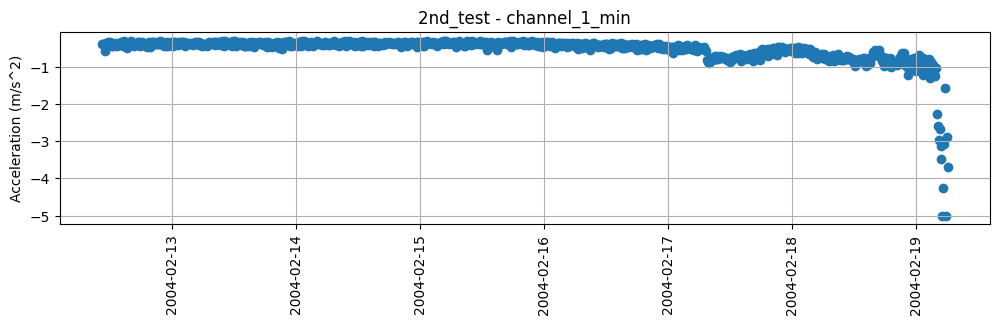

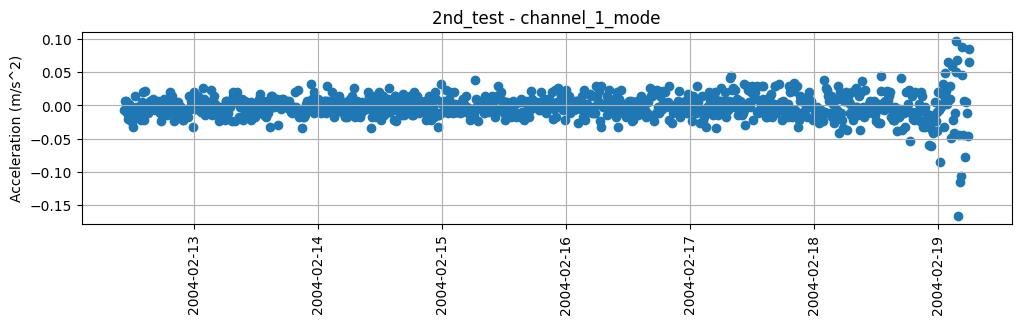

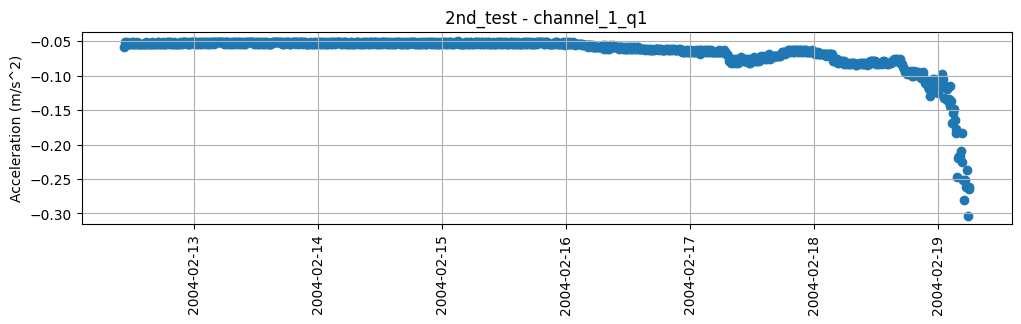

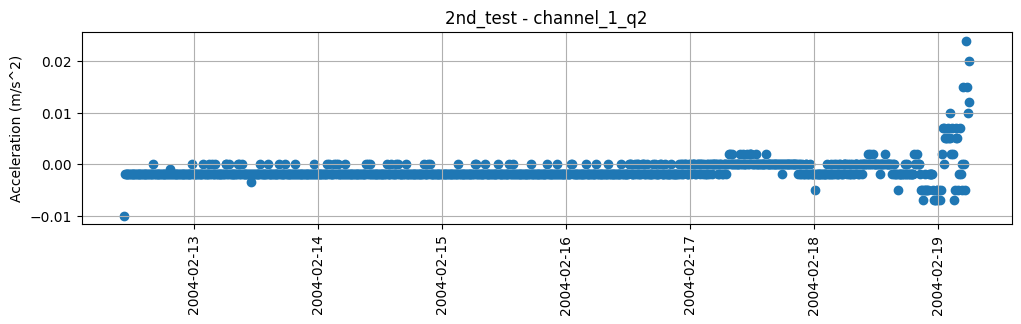

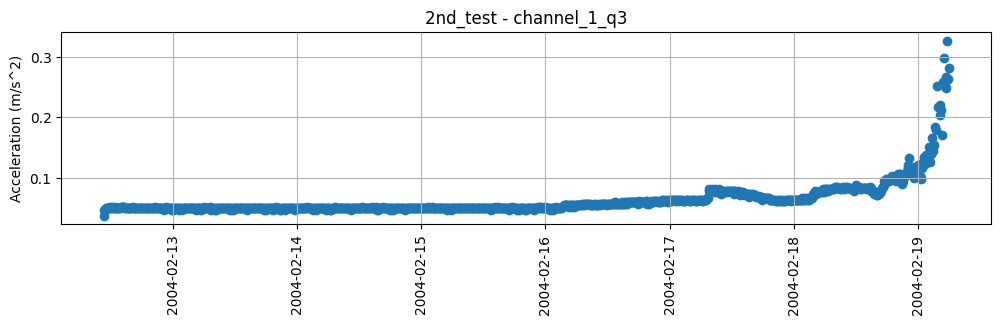

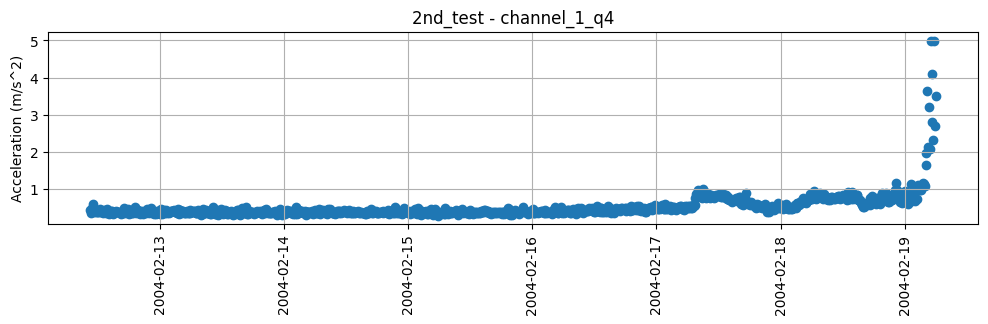

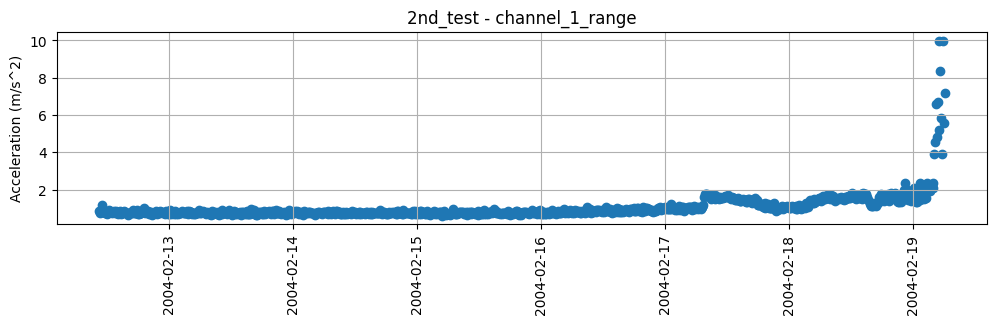

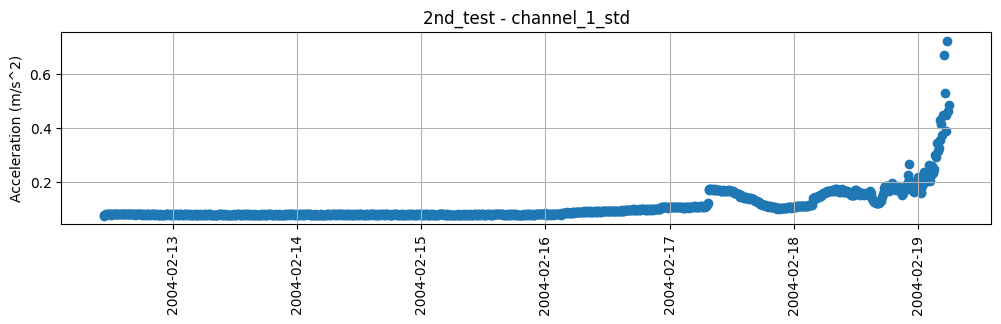

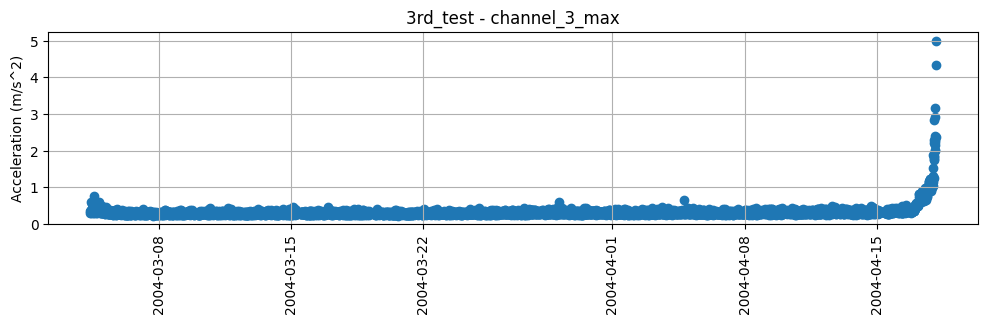

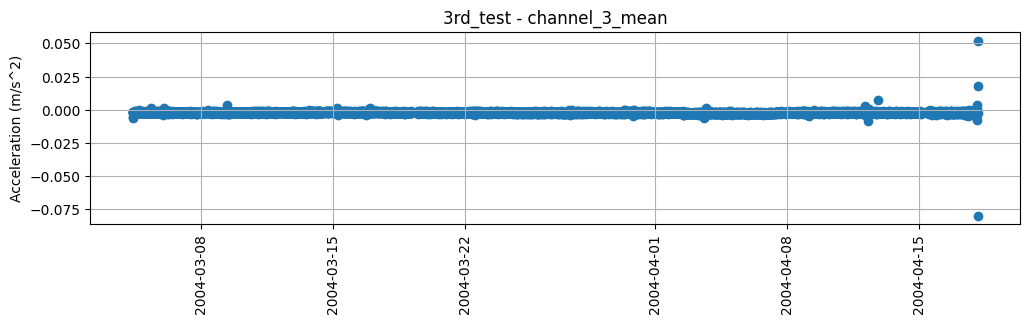

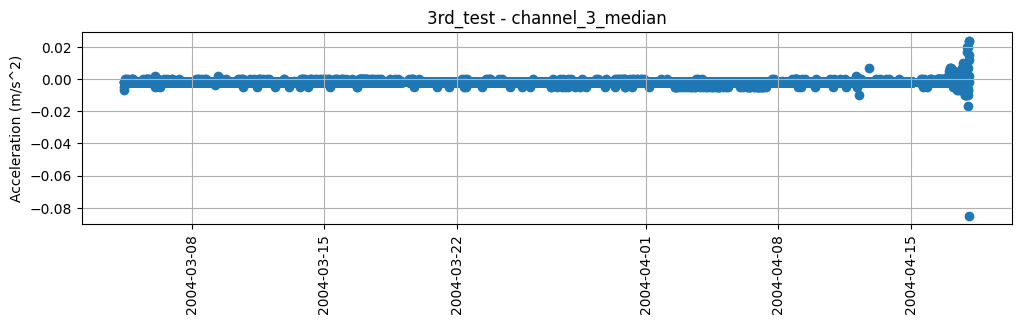

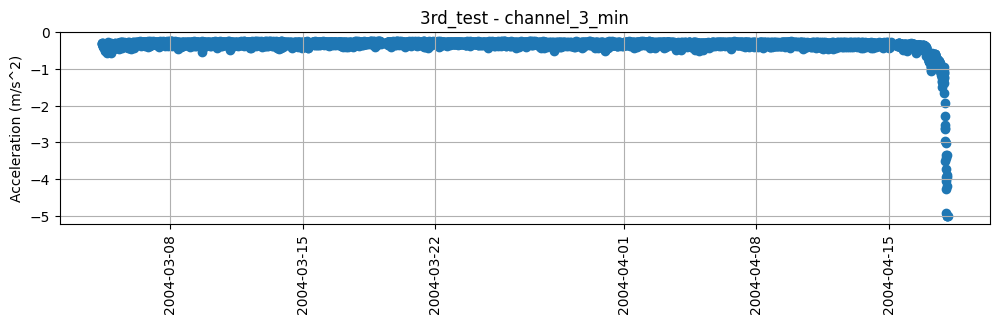

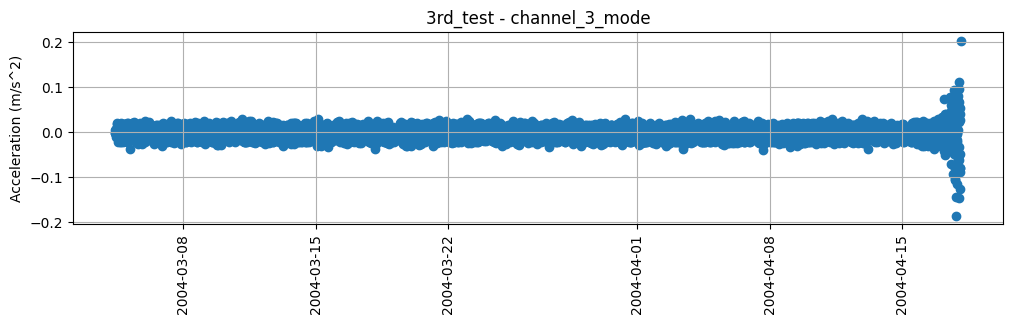

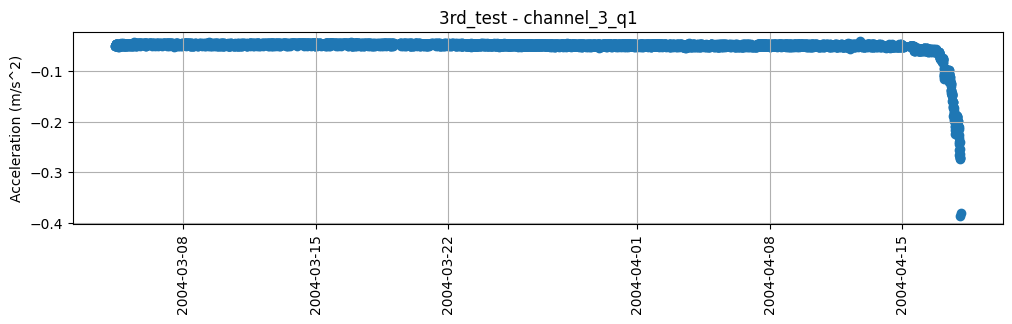

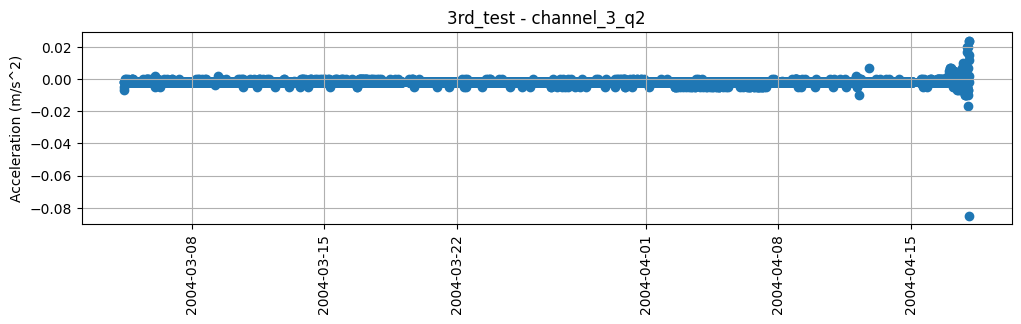

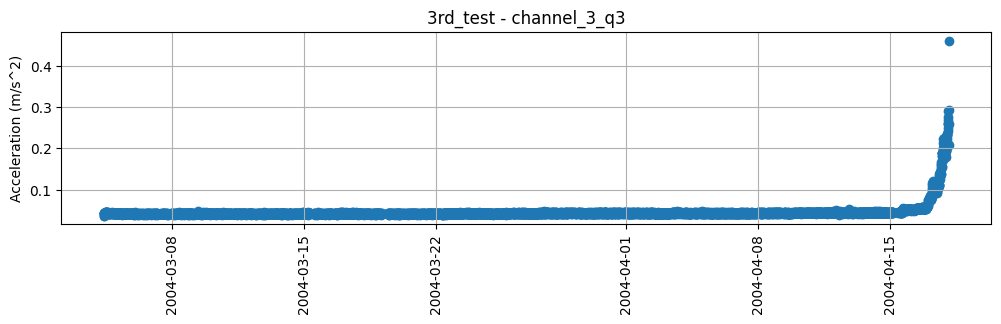

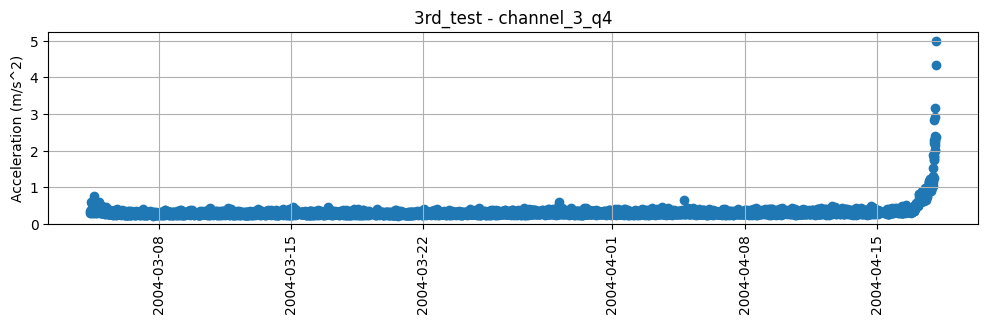

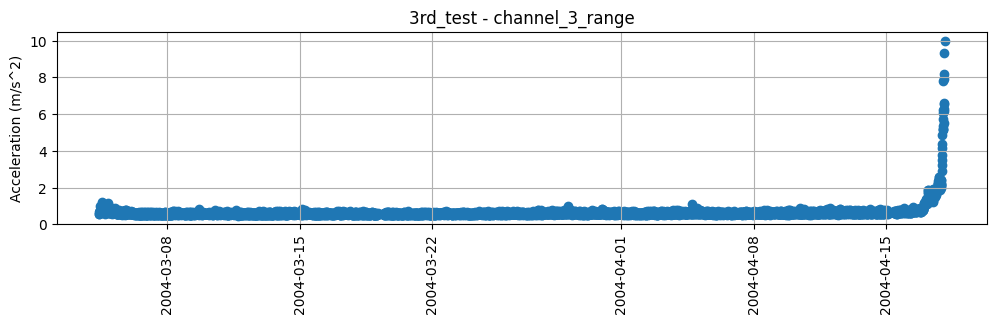

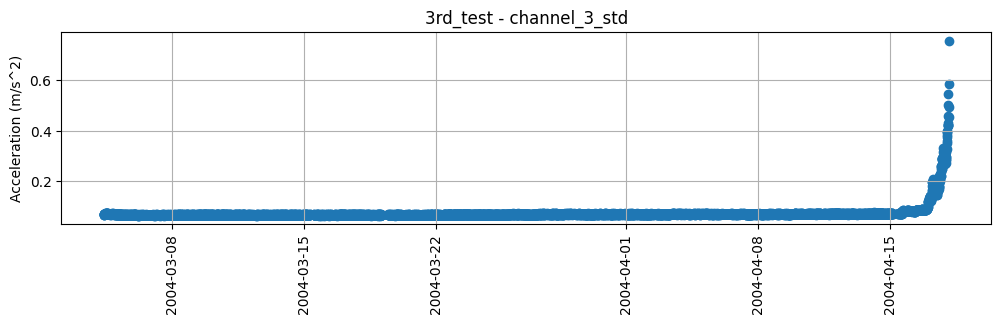

In [11]:
for test, aggregated_df in aggregated_df_per_test.items():
    plot_columns = np.sort(np.array([i for i in aggregated_df.columns if 'channel' in i]))

    for plot_column in plot_columns:
        plt.figure(figsize=(12, 2.5))
        plt.scatter(aggregated_df['date_time'], aggregated_df[plot_column])
        plt.ylabel('Acceleration (m/s^2)')
        plt.xticks(rotation=90)
        plt.title(f'{test} - {plot_column}')
        plt.grid()